(Normalizing_Flows)=

# Normalizing Flows in Pytensor

:::{post} August 17, 2025 
:tags: Graph rewrites 
:category: avanced, explanation 
:author: Jesse Grabowski, Ricardo Vieira
:::


A hip new algorithm for doing machine learning on distributions is called *normalizing flows*. 

The idea begins with the change of variables formula. We begin with a random variable $X \sim N(0, 1)$. Suppose we know the PDF for $X$ (because we do!). What if we instead wanted the PDF for $ Y = \exp(X)$. Do we know that? 

The answer is yes! We know it because of the *change of variable* formula, which states:

$$
g(y) = (f \circ G^{-1})(y) \left | \frac{\partial}{\partial x} G^{-1}(y) \right |
$$

Where:

- $g(\cdot)$ is the (unknown!) PDF of the variable $Y$
- $f(\cdot)$ if the (known!) PDF of the variable $X$
- $G(\cdot)$ is a function with nice properties.

The "nice properties" require (in the most general case) that $G(x)$ is a $C^1$ diffeomorphism, which means that it is 1) continuous and differentiable almost everywhere; 2) it is bijective, and 3) its derivaties are also bijective. 

A simpler requirement is that $G(x)$ is continuous, bijective, and monotonic. That will get us 99% of the way there. Hey, $\exp$ is continuous, bijective, and monotonic -- what a coincidence!


## Prepare Notebook

In [1]:
import preliz as pz
import numpy as np
import matplotlib.pyplot as plt
from abc import ABC
import arviz as az
from scipy.optimize import minimize
import pytensor
import pytensor.tensor as pt
import pymc as pm
from pytensor.tensor.basic import TensorVariable
from pytensor.graph.basic import explicit_graph_inputs
from pytensor.graph.rewriting import rewrite_graph
from pytensor.graph.replace import vectorize_graph


plt.style.use("seaborn-v0_8")

%config InlineBackend.figure_format = "retina"

## Simple Example: Change of Variables Formula

Let's visualize this result through a concrete example. We look at the transformation of a normal distribution to a lognormal distribution.

/var/folders/wj/wjy2vm8d7_j9v43bv29zcgl80000gq/T/ipykernel_68377/3841225381.py:9: RuntimeWarning: invalid value encountered in log
  G_inv = lambda x: np.where(x > 0, np.log(x), 0)


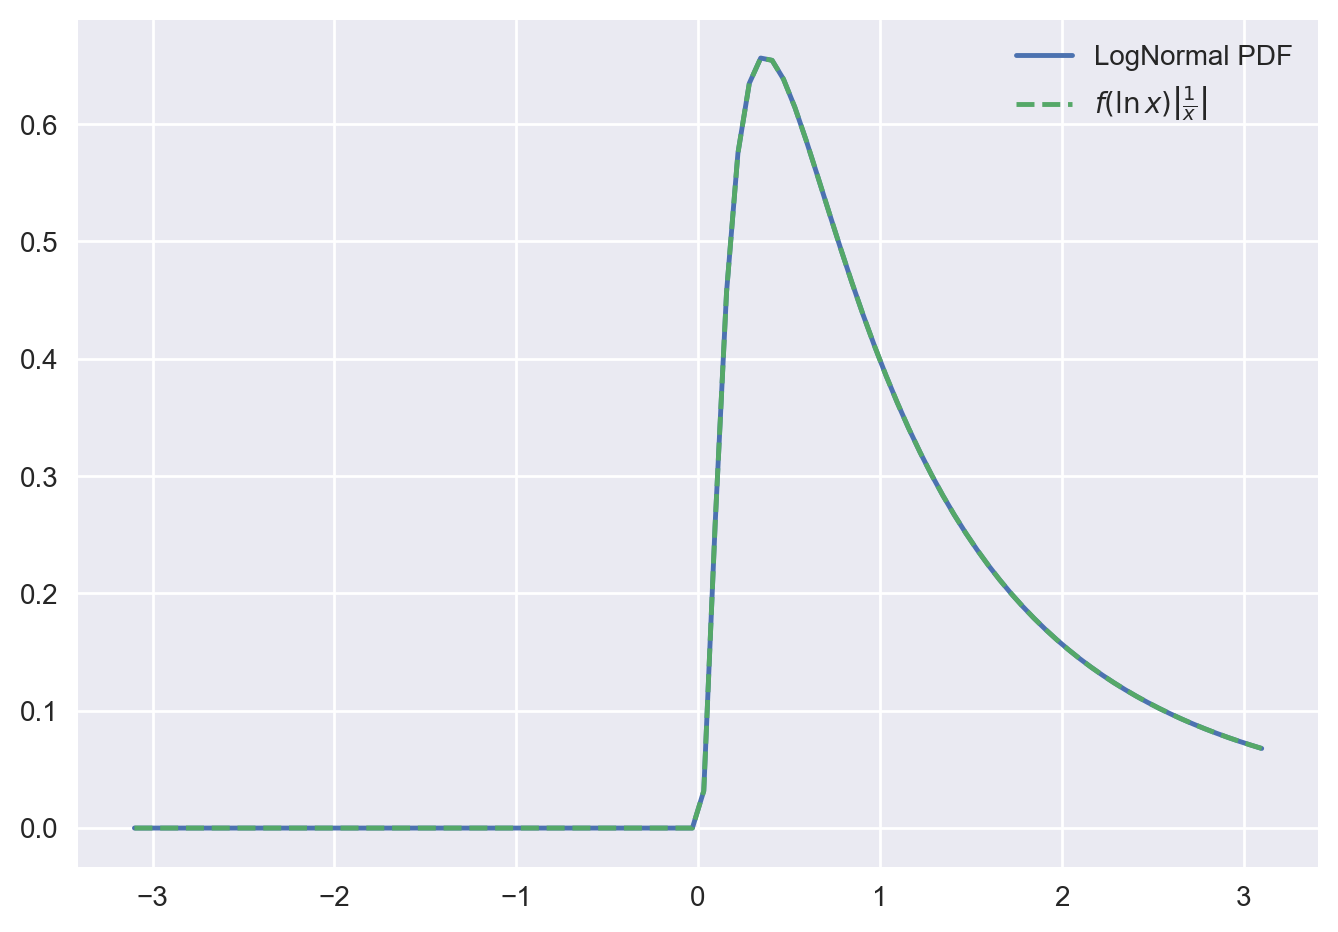

In [2]:
X = pz.Normal(0, 1)
Y = pz.LogNormal(0, 1)

x_grid = np.linspace(-3.1, 3.1, 100)

f_values = X.pdf(x_grid)

# This is just a convenient trick: setting the value to 0 if x <= 0
G_inv = lambda x: np.where(x > 0, np.log(x), 0)
d_G_inv = lambda x: np.where(x > 0, np.reciprocal(x), 0)
g_values = (X.pdf(G_inv(x_grid))) * np.abs(d_G_inv(x_grid))

fig, ax = plt.subplots()
ax.plot(x_grid, Y.pdf(x_grid), c="C0", label='LogNormal PDF')
ax.plot(x_grid, g_values, c="C1", ls='--', label=r'$f(\ln x) \left | \frac{1}{x} \right |$')
ax.legend();

## Normalizing Flows in Pytensor

This change of variables is basically all we need to understand normalizing flows. The logic goes like this:

1. Suppose we have some data $\mathcal{D} \sim D(\cdot)$, where $D$ is totally unknown.
2. We would like to sample from $D$, which seems hard since we don't know it.
3. Instead of sampling from $D$, let's instead sample $F(\cdot)$, where we get to choose $F$ to be as simple as possible. Say it's just $N(0, 1)$
4. Then, we'll use a change of variables to make draws from $F$ _look like_ draws from $D$. 
5. We just need a function $G(x)$ that makes *samples* $x \sim N(0, 1)$ look like our data.
6. $G$ needs to have the nice properties we want: monotonic, bijective, and invertible. And, we'd  like it to have some parameters to learn!

Let's define a simple base class to represent normalizing flows in PyTensor.

In [3]:
class Flow(ABC):
    __slots__ = ('parameters', )
    
    def transform(self, x: TensorVariable) -> TensorVariable:
        """Apply function F to the distribution x, along with the jacobian correction"""
        ...
        
    def inverse_transform(self, x: TensorVariable) -> TensorVariable:
        """Apply inverse function F^{-1} to the distribtuion x"""
        ...        

We can now specify two concrete examples:

In [4]:
class Exp(Flow):     
    """Exponential transformation"""   
    def transform(self, x: TensorVariable) -> TensorVariable:
        return pt.exp(x)
        
    def inverse_transform(self, x: TensorVariable) -> TensorVariable:
        return pt.log(x)

class Affine(Flow):
    """Affine transformation"""
    __slots__ = ('loc', 'scale', 'parameters')
    def __init__(self, loc=0, scale=1):
        self.loc = pt.as_tensor_variable(loc)
        self.scale = scale
        
    def transform(self, x: TensorVariable) -> TensorVariable:
        return self.loc + self.scale * x
    
    def inverse_transform(self, x: TensorVariable) -> TensorVariable:
        return (x - self.loc) / self.scale


As the composition of two flows is itself a flow, we can define a class that composes them:

In [5]:
def compose(*fns):
    def f(x):
        for fn in fns:
            x = fn(x)
        return x
    return f

Let's use these classes to generate a normalizing flow computational graph.

In [6]:
# Random number generation
rng = pytensor.shared(np.random.default_rng(), name='rng')
# Sample from a normal distribution
x = pt.random.normal(0, 1, rng=rng)

# Define the parameters of the affine transformation
loc, scale = pt.dscalars('loc', 'scale')
# Define the transformations
transforms = [Affine(loc=loc, scale=scale), Exp()]
# Compose the transformations
flow = compose(*[x.transform for x in transforms])
# Apply the transformations to the random variable
z = flow(x)

# Print the resulting graph
z.dprint()

Exp [id A]
 └─ Add [id B]
    ├─ loc [id C]
    └─ Mul [id D]
       ├─ scale [id E]
       └─ normal_rv{"(),()->()"}.1 [id F]
          ├─ rng [id G]
          ├─ NoneConst{None} [id H]
          ├─ 0 [id I]
          └─ 1 [id J]


We can now compute the log-density of the transformed variable.

In [7]:
z_values = pt.dvector('z_values')
z_logp = pm.logp(z, z_values, jacobian=True)
# We do this rewrite to make the computation mre stable.
rewrite_graph(z_logp).dprint()

Switch [id A] 'z_values_logprob'
 ├─ Isnan [id B]
 │  └─ Mul [id C]
 │     ├─ [-1.] [id D]
 │     └─ Log [id E]
 │        └─ z_values [id F]
 ├─ [-inf] [id G]
 └─ Add [id H]
    ├─ Switch [id I]
    │  ├─ Isnan [id J]
    │  │  └─ Mul [id K]
    │  │     ├─ [-1.] [id D]
    │  │     └─ Log [id L]
    │  │        └─ Abs [id M]
    │  │           └─ Alloc [id N]
    │  │              ├─ scale [id O]
    │  │              └─ Squeeze{axis=0} [id P]
    │  │                 └─ Shape [id Q]
    │  │                    └─ Sub [id R]
    │  │                       ├─ Log [id E]
    │  │                       │  └─ ···
    │  │                       └─ ExpandDims{axis=0} [id S]
    │  │                          └─ loc [id T]
    │  ├─ [-inf] [id G]
    │  └─ Add [id U]
    │     ├─ Check{sigma > 0} [id V]
    │     │  ├─ Add [id W]
    │     │  │  ├─ [-0.91893853] [id X]
    │     │  │  └─ Mul [id Y]
    │     │  │     ├─ [-0.5] [id Z]
    │     │  │     └─ Pow [id BA]
    │     │  │        ├─ 

From the log-density graph, we can extract the inputs and outputs of the it.

In [8]:
inputs = list(explicit_graph_inputs(z_logp))
inputs

[z_values, scale, loc]

In [9]:
z_values, scale, loc = inputs

We proceed to compile the graph into a function so we can do actual computations.

In [10]:
f_logp_pymc = pytensor.function([z_values, loc, scale], z_logp)

We verify that the resulting log-density of the transformed variable is the same as the log-density of a `LogNormal` distribution, which is precisely what we expect.

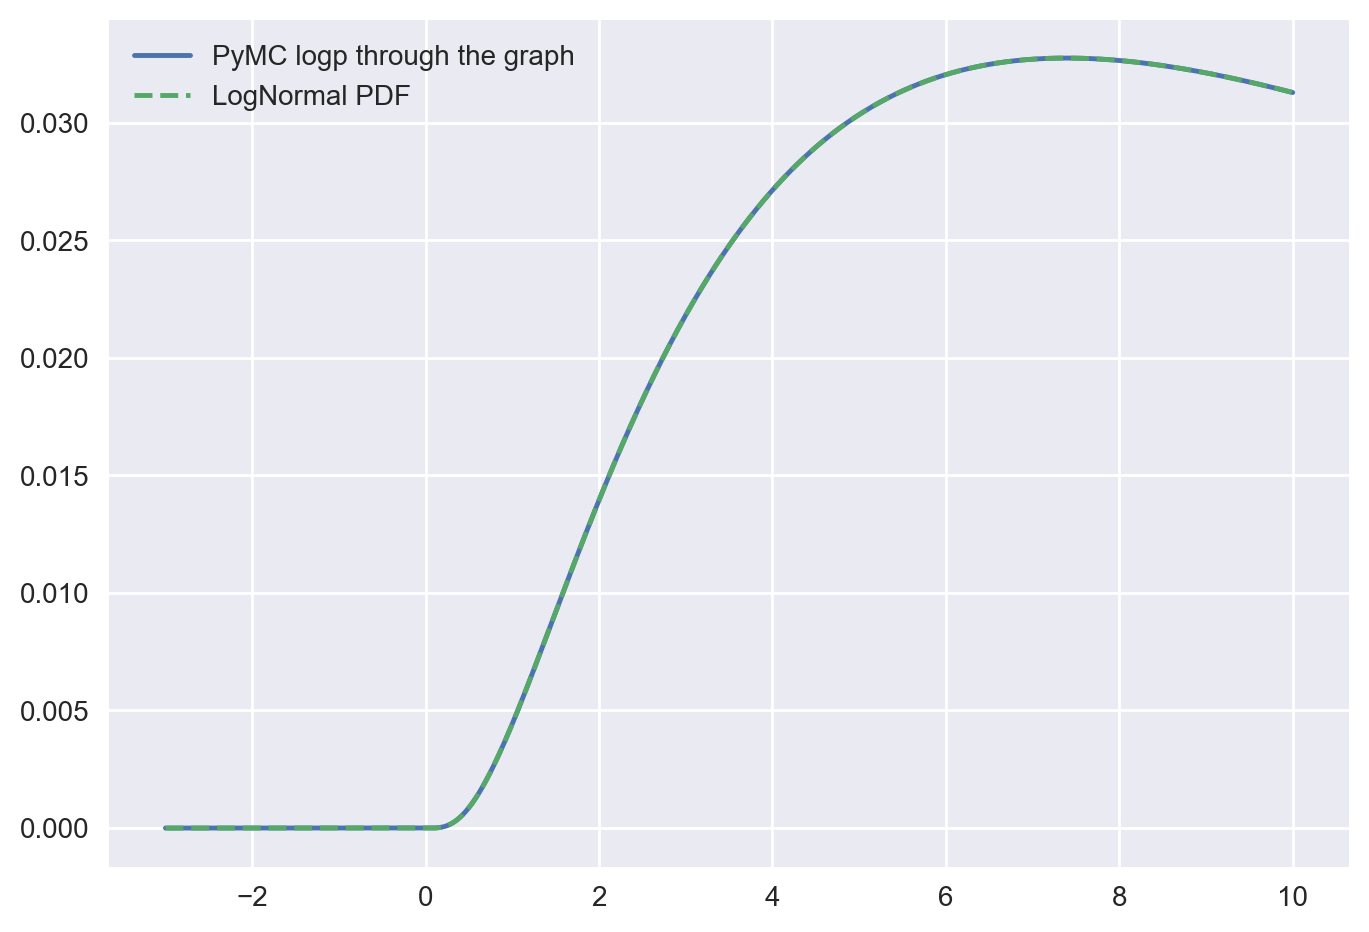

In [11]:
x_grid = np.linspace(-3, 10, 1000)
plt.plot(x_grid, np.exp(f_logp_pymc(z_values=x_grid, loc=3, scale=1.0)), c="C0", label="PyMC logp through the graph")
plt.plot(x_grid, pz.LogNormal(mu=3, sigma=1).pdf(x_grid), ls='--', c="C1", label="LogNormal PDF")
plt.legend();

## Learn loc and scale

Suppose we just have samples from some "unknown" lognormal, we can learn parameters `loc` and `scale` by maximizing the log likelihood of the data

In [12]:
samples = pz.LogNormal(mu=2.234, sigma=0.99354).rvs(5_000)

objective = -pm.logp(z, z_values, jacobian=True).mean()

grad_objective = pt.stack(pt.grad(objective, [loc, scale]))
f_obj_grad = pytensor.function([z_values, loc, scale], [objective, grad_objective])

# It would be nicer to just use the hessian function, but pytensor is fussy and doesn't like
# scalar inputs
hess = pt.stack(pytensor.gradient.jacobian(pt.stack(pt.grad(objective, [loc, scale])), [loc, scale]), axis=0)
f_hess = pytensor.function([z_values, loc, scale], hess)

f_sample = pm.compile([loc, scale], z)

In [13]:
res = minimize(lambda x, *args: f_obj_grad(*args, *x),
         jac=True,
         hess=lambda x, *args: f_hess(*args ,*x),
         method='Newton-CG',
         x0=[0.8, 0.8],
         args=(samples, ),
         tol=1e-12)
res

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 3.626489370740259
       x: [ 2.226e+00  9.818e-01]
     nit: 10
     jac: [ 3.093e-13 -5.393e-12]
    nfev: 12
    njev: 12
    nhev: 10

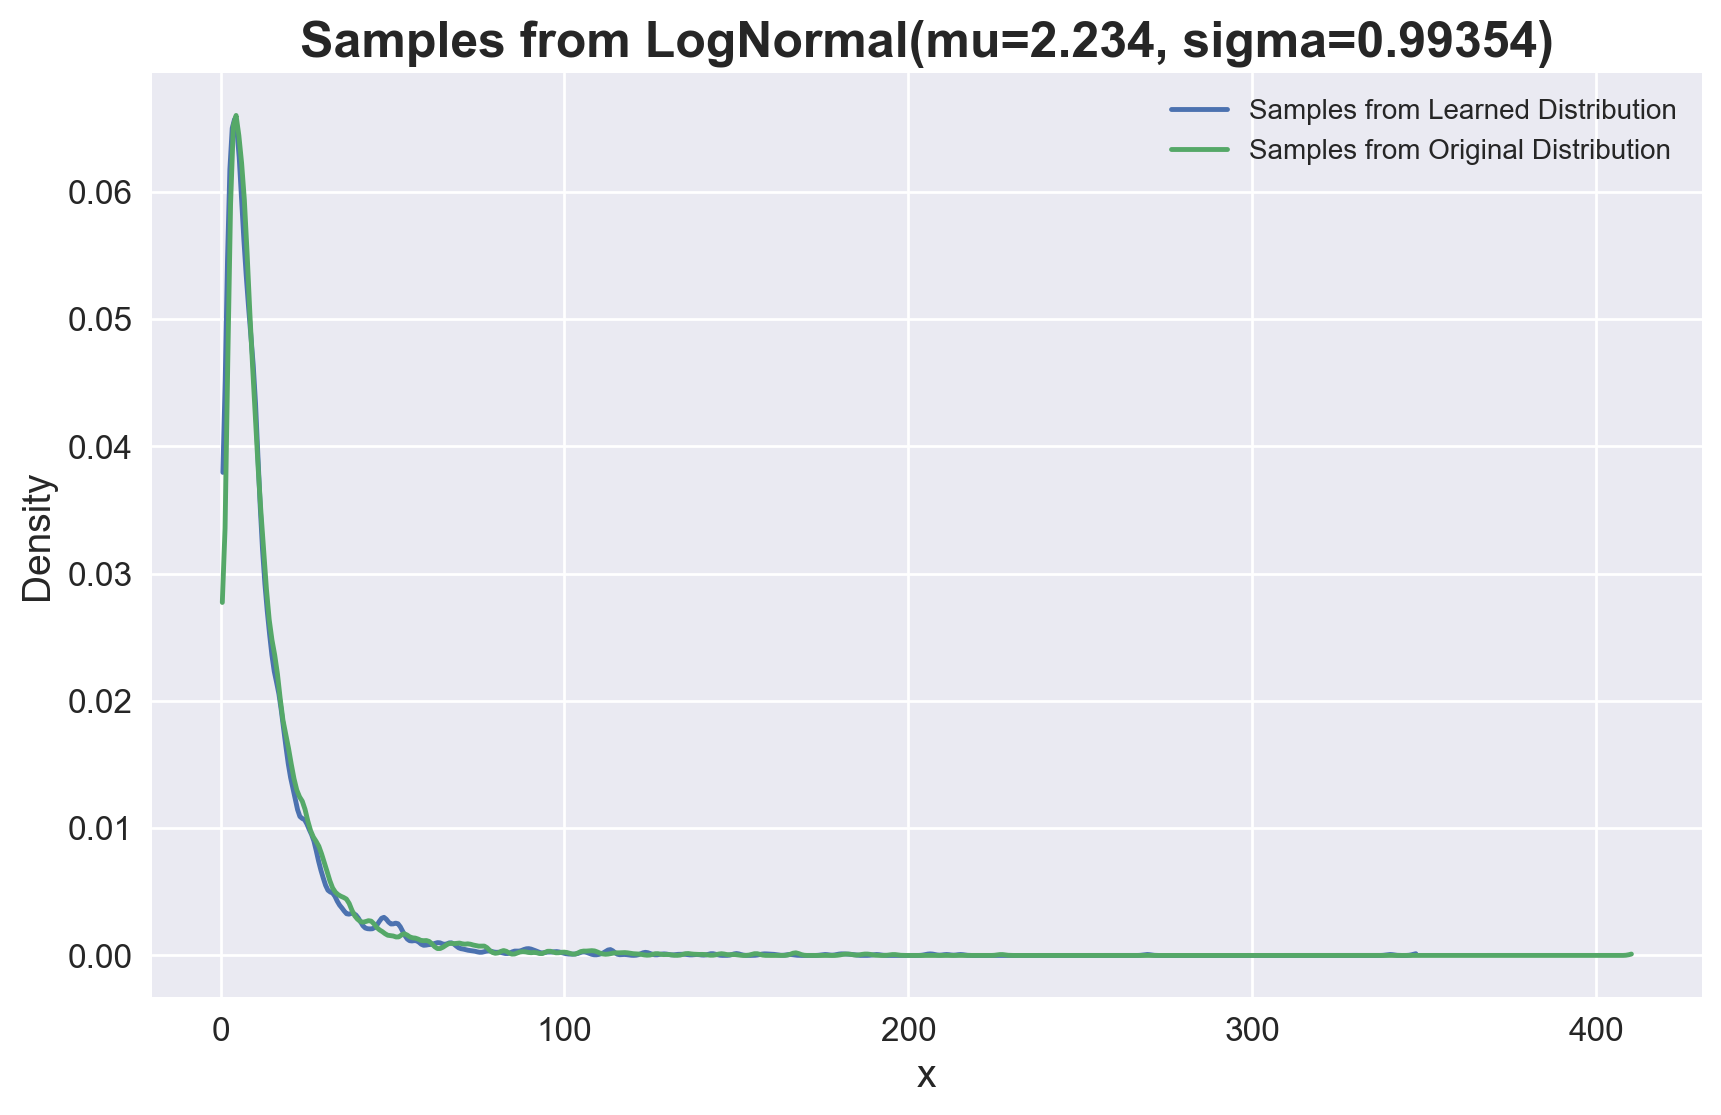

In [14]:
fig, ax = plt.subplots(figsize=(10, 6))
az.plot_kde(np.r_[*[f_sample(*res.x) for _ in range(5_000)]], plot_kwargs={'c':'C0', 'label': 'Samples from Learned Distribution'}, ax=ax)
az.plot_kde(samples, plot_kwargs={'c':'C1', 'label': 'Samples from Original Distribution'}, ax=ax)
ax.legend()
ax.set_xlabel("x", fontsize=14)
ax.set_ylabel("Density", fontsize=14)
ax.tick_params(labelsize=12)
ax.set_title("Samples from LogNormal(mu=2.234, sigma=0.99354)", fontsize=18, fontweight="bold");

# Reproducing what PyMC does

Most of the heavy lifting here was done by PyMC. It already knows how to handle the change-of-variables formula for a wide variety of functions, including $\exp$ and affine shifts. That's why things just sort of magically worked up until now. 

Recall the formula for change of variables:

$$
g(x) = (f \circ G^{-1})(x) \left | \frac{\partial}{\partial x} G^{-1}(x) \right |
$$

Right now in the graph of $z$, we just have draws from $x$, passed through the function $G$. Or:

$$
z = G(x) 
$$

To get to where we want to go, we need to:

1. Iterate backwards over all the flows, applying the inverse function to the incoming samples
2. At the same time, we also need to compute $\left | \frac{\partial}{\partial x} G^{-1}(x) \right | $ and accumulate their products
3. We need to get the logp of the original random variable, $f(x)$, and plug in the result of (1) as the value
4. Finally, add the log of the product of the determinant corrections. 

Since in the end we need the log of the determinant, it will be easier to modify step (2) to accumulate the sum of the log determinant of the transformations

## In detail

We have two transformations, $H(x) = \exp(x)$ and $J(x) = a + bx$. Define $G$ as their composition, $G \equiv (H \circ J)(x) = \exp(a + bx)$

For inverses, we have $H^{-1}(x) = \ln(x)$ and $J^{-1}(x) = \frac{x - a}{b}$

So, the inverse of their composition is $G^{-1} \equiv (J^{-1} \circ H^{-1}) = J^{-1}(H^{-1}(x)) = J^{-1}(\ln(x)) = \frac{\ln(x) - a}{b}$

For the correction term, we need the determinant of the jacobian. Since $G$ is a scalar function, this is just the absolutel value of the gradient:

$$\left | \frac{\partial}{\partial x}G^{-1} \right | = \left | \frac{\partial}{\partial x} \frac{\ln(x) - a}{b} \right | = \left | \frac{1}{b} \cdot \frac{1}{x} \right | $$

We we will compute $g(z) = f(\frac{\ln(z) - a}{b}) \left | \frac{1}{b} \cdot \frac{1}{z} \right |$, where $f(x) = \frac{1}{\sqrt{2\pi}}\exp(-\frac{x^2}{2})$ is a standard normal PDF.

Of course we'll work with the logp, so we will actually have:

$$\ln g(z) = -\frac{1}{2}\ln{\sqrt{2\pi}} - \frac{1}{2}\left (\frac{\ln z - a}{b} \right )^2 - \ln{\left | b \right |} - \ln{\left | z \right |}$$

In [15]:
def standard_normal_logp(x):
    x = pt.as_tensor_variable(x)
    
    kernel = -x ** 2 / 2
    normalizing_constant = -0.5 * pt.log(2 * np.pi)
    return normalizing_constant + kernel

In [16]:
# Solution by hand
loc, scale = transforms[0].loc, transforms[0].scale
z_star = (pt.log(z_values) - loc) / scale
analytic = standard_normal_logp(z_star) - pt.log(pt.abs(scale)) - pt.log(pt.abs(z_values))
f_analytic = pytensor.function([z_values, loc, scale], analytic)

In [17]:
f_analytic(samples, loc=3, scale=1)

array([-3.74561592, -3.58570101, -3.67848324, ..., -4.05338878,
       -3.44012189, -5.01791472], shape=(5000,))

In [18]:
pz.LogNormal(mu=3, sigma=1).logpdf(samples)

array([-3.74561592, -3.58570101, -3.67848324, ..., -4.05338878,
       -3.44012189, -5.01791472], shape=(5000,))

Now we do it again using autodiff. We need the absolute value of the gradient through the whole composite transformation. We do it on a dummy scalar $x$, then vectorize back up to `z_values`, since that's the behavior we want.

We could also do `pt.grad(f_inverse(z_values).sum(), z_values)`, and rely on the fact that the sum function introduces no cross-terms in the gradient expression. This would be the same, but would require you to grok this math fact. I also like that the vectorize way shows off `vectorize_graph` again :)

In [19]:
x = pt.dscalar('x')
inverse_flows = [f.inverse_transform for f in reversed(transforms)]

f_inverse = compose(*inverse_flows)
log_jac_det = pt.log(pt.abs(pt.grad(f_inverse(x), x)))
log_jac_det = vectorize_graph(log_jac_det, {x:z_values})

inverse_flow = standard_normal_logp(f_inverse(z_values)) + log_jac_det
f_logp_flow = pytensor.function(list(explicit_graph_inputs(inverse_flow)), inverse_flow)

In [20]:
f_logp_flow(samples, loc=3, scale=1)

array([-3.74561592, -3.58570101, -3.67848324, ..., -4.05338878,
       -3.44012189, -5.01791472], shape=(5000,))

In [21]:
f_logp_pymc(samples, loc=3, scale=1)

array([-3.74561592, -3.58570101, -3.67848324, ..., -4.05338878,
       -3.44012189, -5.01791472], shape=(5000,))

## Re-do optimization using our new implementation

In [22]:
objective = -inverse_flow.mean()

grad_objective = pt.stack(pt.grad(objective, [loc, scale]))
f_obj_grad = pytensor.function([z_values, loc, scale], [objective, grad_objective])

hess = pt.stack(pytensor.gradient.jacobian(pt.stack(pt.grad(objective, [loc, scale])), [loc, scale]), axis=0)
f_hess = pytensor.function([z_values, loc, scale], hess)

In [23]:
res = minimize(lambda x, *args: f_obj_grad(*args, *x),
         jac=True,
         hess=lambda x, *args: f_hess(*args, *x),
         method='Newton-CG',
         x0=[0.8, 0.8],
         args=(samples,),
         tol=1e-12)
res

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 3.6264893707402597
       x: [ 2.226e+00  9.818e-01]
     nit: 10
     jac: [ 3.093e-13 -5.388e-12]
    nfev: 12
    njev: 12
    nhev: 10

## Authors

- Authored by Jesse Grabowski and Ricardo Vieira in August 2025

## References

:::{bibliography} :filter: docname in docnames

## Watermark 

In [24]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

Last updated: Sun Aug 17 2025

Python implementation: CPython
Python version       : 3.12.11
IPython version      : 9.4.0

pytensor: 2.31.7

numpy     : 2.2.6
scipy     : 1.16.1
pytensor  : 2.31.7
pymc      : 5.25.1
arviz     : 0.22.0
preliz    : 0.20.0
matplotlib: 3.10.5

Watermark: 2.5.0



:::{include} ../page_footer.md 
:::